# Import libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable

import math
import imp
import numpy as np
import tensorflow as tf
import os
import time
import dataprocessing as dp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from Models_3DRFB_Attention_GRU_Stateful import Model_3D
from Parts import *
import easydict
import csv
import pandas as pd

from sklearn.metrics import accuracy_score

# Main Function


Current cuda device  0
lead phase : [1/2]
ensemble phase : [1/6]
ensemble phase : [2/6]
ensemble phase : [3/6]
ensemble phase : [4/6]
ensemble phase : [5/6]
ensemble phase : [6/6]
0.9421379332797689
Save prediction: lead = 0


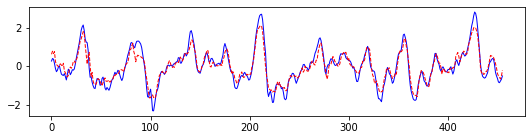

0.9319439619416356
Save prediction: lead = 1


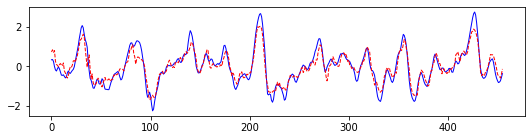

0.8966552328388538
Save prediction: lead = 2


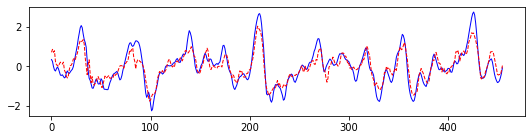

0.8610413868810155
Save prediction: lead = 3


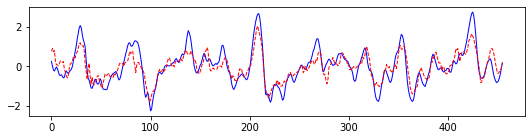

0.8185581819813459
Save prediction: lead = 4


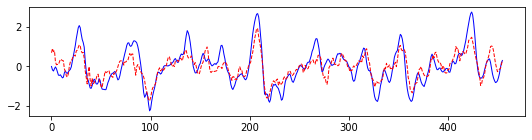

0.7685809075719311
Save prediction: lead = 5


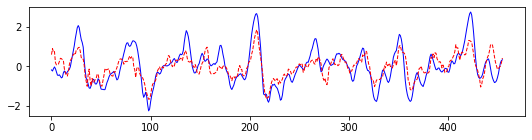

0.7192630721986629
Save prediction: lead = 6


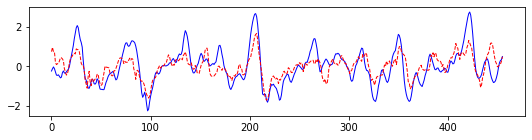

0.6716851500735984
Save prediction: lead = 7


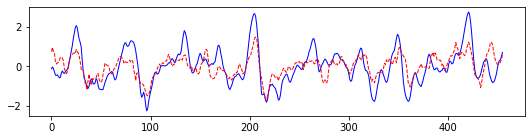

0.6345827544337217
Save prediction: lead = 8


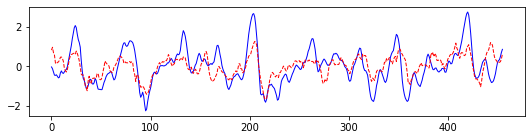

0.6002318486729011
Save prediction: lead = 9


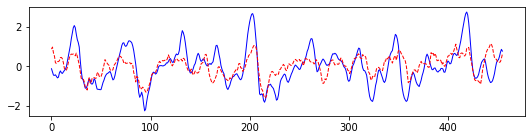

0.5614188061787643
Save prediction: lead = 10


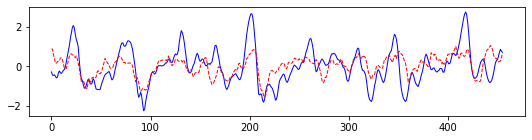

0.5190350374274574
Save prediction: lead = 11


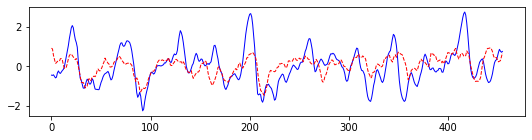

0.48464336430881194
Save prediction: lead = 12


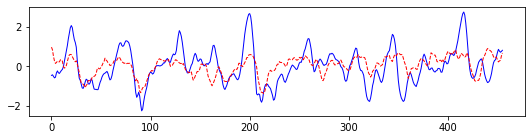

0.4535841199826791
Save prediction: lead = 13


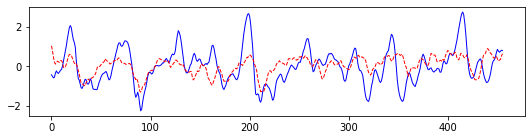

0.428311378195217
Save prediction: lead = 14


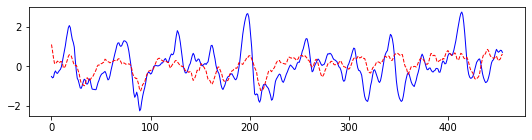

0.4145147689065964
Save prediction: lead = 15


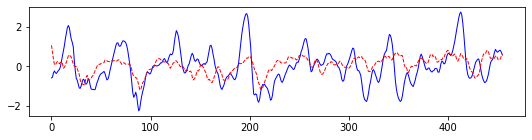

0.4004106406022801
Save prediction: lead = 16


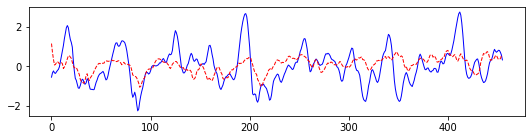

0.3881329865709382
Save prediction: lead = 17


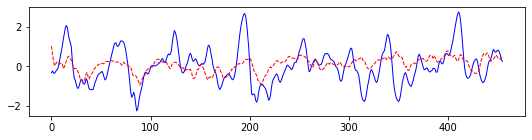

0.37708428005486067
Save prediction: lead = 18


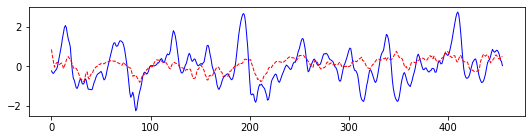

0.3583577537560168
Save prediction: lead = 19


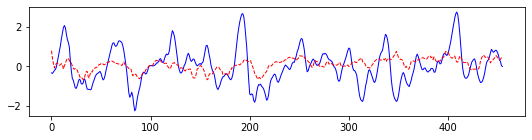

0.34344091293378637
Save prediction: lead = 20


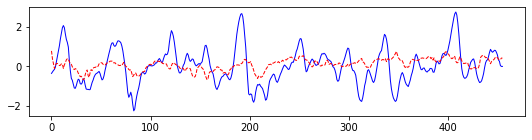

0.321387946145639
Save prediction: lead = 21


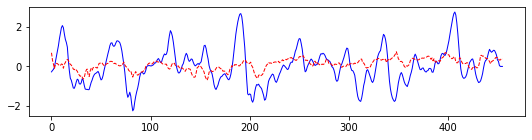

0.30960447170290467
Save prediction: lead = 22


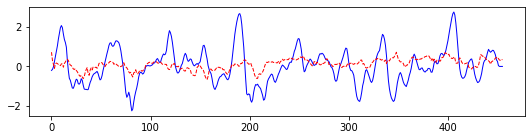

Save classification: lead = 22


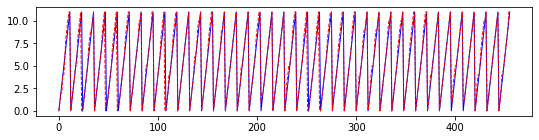

Accuracy = [0.73245614]


In [2]:
if __name__ == "__main__":
    # Random seed 
    # torch.backends.cudnn.deterministic = True 
    # torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)

    # Arguments
    args = easydict.EasyDict({
        "startLead": 1,
        "endLead": 2,
        "gpu": 0,
        "input": 3
    })

    # Directories
    # Dataset for pretrain
    Folder = "./pretrain_3DRFB_Attention_GRU_Stateful_3/"
    dataFolder = "./" #"./""./"

#     # Dataset for finetuning
#     Folder = "./finetuning_3DRFB_Attention_3"
#     dataFolder = "./"
    
    SSTFile_val = dataFolder+'/Data_validation/godas.input.1980_2017.nc'
    SSTFile_val_label = dataFolder+'/Data_validation/godas.label.1980_2017.nc'

    device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() else 'cpu')
    torch.cuda.set_device(device) # change allocation of current GPU
    print ('Current cuda device ', torch.cuda.current_device()) # check

    # Set Hyper-parameters
    regularizer_rate = 0.00001  #L2 regularization
    numEpoch =  40              # No. Epoch
    learning_rate = 0.0001      # Initial Learning Rate
    n_cycles = 4                # No. cycles in Cosine Annealing
    epochs_per_cycle = math.floor(numEpoch / n_cycles)  # No. epochs for each cycle

    dr = 0.0                   # Dropout rate for Bayesian learning
    tau = 1.0                   # Weight for the batch size in regularization weight calculation (Bayesian learning)
    lengthscale = 1e-2          # Default regularization weight (L2)
    noF = 16                    # Initial No. filters
    num_layer = 256             # Feature size of 1st fully-connected layer
    num_answer = 2              # No. answers(3=3.4/ep/cp)

    ENS_Start = 0
    ENS = 6
    # loop - 1 time only
    for lead in range(args.startLead, args.endLead) :
        print('lead phase : [{}/{}]'.format(lead, args.endLead))

        # Dataset for training
        valset = datasets_general_3D_alllead(SSTFile_val, SSTFile_val_label, lead, sstName='sst', hcName='t300', labelName='pr', noise = False)
        batch_size = len(valset) // 1                             # batch size
        reg = lengthscale**2 * (1 - dr) / (2. * batch_size * tau) # L2 regularization weight for Bayesian learning
        testloader = DataLoader(valset, batch_size = batch_size, shuffle=False)

        test_step = len(testloader)
        assemble_real_type = np.zeros((len(valset)))
        assemble_pred_type = np.zeros((len(valset)))
        assemble_pred_prop = np.zeros((len(valset), 12))

        assemble_real_nino = np.zeros((len(valset), 23))
        assemble_pred_nino = np.zeros((len(valset), 23))
        for ens in range(ENS_Start, ENS) :
            print('ensemble phase : [{}/{}]'.format(ens+1, ENS))

            model = Model_3D(2, noF, num_layer, num_answer, dr, args.input).to(device)
            model.load_state_dict(torch.load('{}/train_{}_{}/train_{}_{}.pth'.format(Folder, lead, ens, lead, ens)))
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=regularizer_rate, betas=(0.9, 0.999))
            model.eval()
            
            bayesianIter = 1

            with torch.no_grad() :
                for i, (batch, ansnino, anstype) in enumerate(testloader):
                    batch = Variable(batch.float().cuda())
                    ansnino = Variable(ansnino.float().cuda())
                    anstype = Variable(anstype.float().cuda())
                    idx = batch_size*i
                    uncertaintyarry_nino = np.zeros((bayesianIter, batch_size, 23))
                    uncertaintyarry_type = np.zeros((bayesianIter, batch_size, 12))
                    for b in range(int(bayesianIter)):
                        output = model(batch) # inference
                        prednino = np.squeeze(output[0], axis=2)
                        uncertaintyarry_nino[b, :, :] = prednino.cpu()
                        uncertaintyarry_type[b, :, :] = torch.nn.functional.softmax(output[1], dim=1).cpu()

                    if ens == 0:
                        assemble_real_nino[idx:idx+batch_size, :] = ansnino.cpu().numpy()
                        anstype = torch.argmax(anstype, dim=1).cpu().numpy()
                        assemble_real_type[idx:idx+batch_size] = anstype

                    assemble_pred_nino[idx:idx+batch_size, :] += np.mean(uncertaintyarry_nino, axis=0)
                    predMean = np.mean(uncertaintyarry_type, axis = 0)
                    # assemble_pred_type[idx:idx+batch_size] += np.argmax(predMean, axis = 1)
                    assemble_pred_prop[idx:idx+batch_size, :] += predMean

                    del batch
                    del ansnino
                    del anstype
        
        # End of ensemble
        assemble_pred_nino /= ENS
        assemble_pred_prop /= ENS
        assemble_pred_type = np.argmax(assemble_pred_prop, axis = 1)

        corr = np.zeros(23)
        for i in range(23):
            corr[i] = dp.CorrelationSkill(assemble_real_nino[:, i], assemble_pred_nino[:, i])
            print(corr[i])
            print('Save prediction: lead = {}'.format(i) )
            inputTimeSeq = assemble_real_nino.shape[0]
            dwidth = 800
            dpi = 90
            dheight = 180
            plt.figure(figsize=(dwidth/dpi, dheight/dpi))
            timeValues = np.arange(0, inputTimeSeq)
            plt.plot(timeValues, assemble_real_nino[:, i], marker='', color='blue', linewidth=1, label="Measurement")
            plt.plot(timeValues, assemble_pred_nino[:, i], marker='', color='red', linewidth=1, linestyle='dashed', label="Prediction")
            plt.savefig(Folder + "/NinoPred_" + str(i).zfill(6) + ".png", orientation='landscape', bbox_inches='tight')
            plt.show()
            plt.close()
        
        np.savetxt(Folder + '/correlation.csv',corr,delimiter=",")
        
        print('Save classification: lead = {}'.format(i) )
        plt.figure(figsize=(dwidth/dpi, dheight/dpi))
        timeValues = np.arange(0, inputTimeSeq)
        plt.plot(timeValues, assemble_real_type, marker='', color='blue', linewidth=1, label="Measurement")
        plt.plot(timeValues, assemble_pred_type, marker='', color='red', linewidth=1, linestyle='dashed', label="Prediction")
        plt.savefig(Folder + "/Month_Classification" + ".png", orientation='landscape', bbox_inches='tight')
        plt.show()
        plt.close()
        accuracy = np.zeros(1)
        accuracy[0] = accuracy_score(assemble_real_type, assemble_pred_type)
        print('Accuracy = {}'.format(accuracy))
        np.savetxt(Folder + '/accuracy.csv',accuracy,delimiter=",")


        # print(assemble_pred_nino)
        np.save("{}/lead_{}_assemble_real_nino".format(Folder, lead), assemble_real_nino) # 길이가 valset인 것이 ensemble 갯수 만큼 들어있음
        np.save("{}/lead_{}_assemble_real_type".format(Folder, lead), assemble_real_type)
        np.save("{}/lead_{}_assemble_pred_nino".format(Folder, lead), assemble_pred_nino)
        np.save("{}/lead_{}_assemble_pred_type".format(Folder, lead), assemble_pred_type)
        np.save("{}/lead_{}_assemble_pred_prop".format(Folder, lead), assemble_pred_prop)

